In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

In [31]:
images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in glob.glob("./data/*.png")]
images = [np.uint8(img / np.max(img) * 255) for img in images]

# zahodit vzorky s nizkym rozlisenim
#images = [img for img in images if img.shape[0]*img.shape[1] > 200*200]
print(f"Number of images: {len(images)}")

Number of images: 15


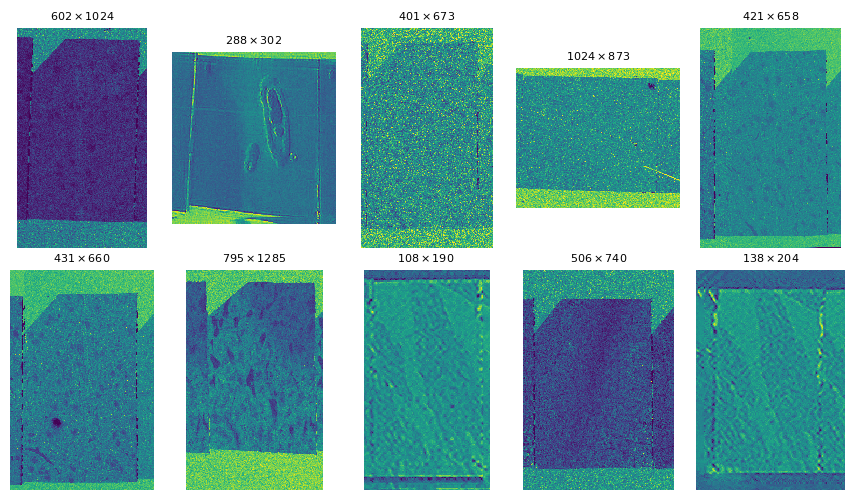

In [32]:
plotted_indices = random.sample(range(len(images)), 10)

def plot_samples(images: list, n: int = 10) -> None:
    global plotted_indices
    imgs = [images[i] for i in plotted_indices]
    _fig, axes = plt.subplots(2, 5, figsize=(11, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
    for ax, img in zip(axes.flat, imgs):
        height, width, *_channels = img.shape
        ax.imshow(img, interpolation="nearest")
        ax.set_title(f"${width}\\times{height}$", fontsize=8)
        ax.axis("off")

    plt.show()

def plot_sample(image: np.ndarray, title: None|str = None) -> None:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title is not None: plt.title(title)
    plt.axis('off')
    plt.show()

plot_samples(images)

In [33]:
def smooth_noise_gb(img):
    w, h = img.shape[:2]
    s = (max(w, h) // 200) * 2 + 1
    sigma = 0.3 * ((s - 1) / 2 - 1) + 0.8
    return cv2.GaussianBlur(img, (s, s), sigma)

def smooth_noise_bf(img):
    w, h = img.shape[:2]
    s = (max(w, h) // 75) + 1
    return cv2.bilateralFilter(img, s, 80, 160)

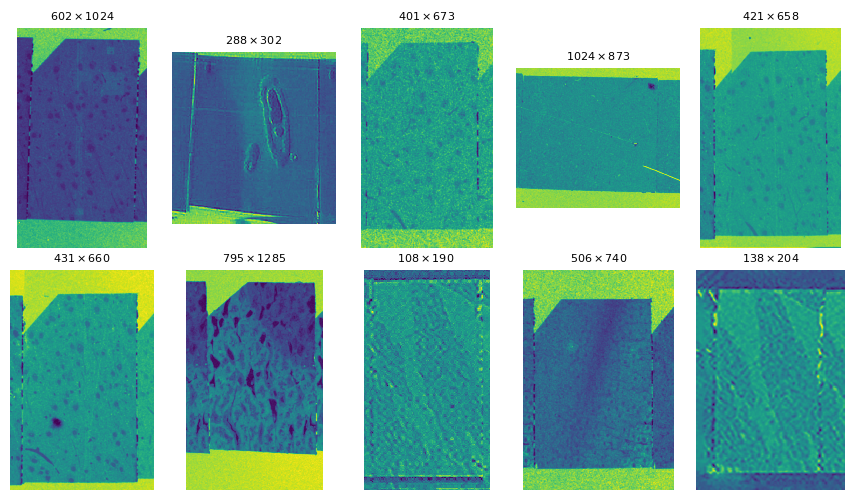

In [34]:
images_bf = [smooth_noise_gb(img) for img in images]
plot_samples(images_bf)

In [35]:
def apply_sobel_filter(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(grad_x, grad_y)
    return np.uint8(sobel / np.max(sobel) * 255)

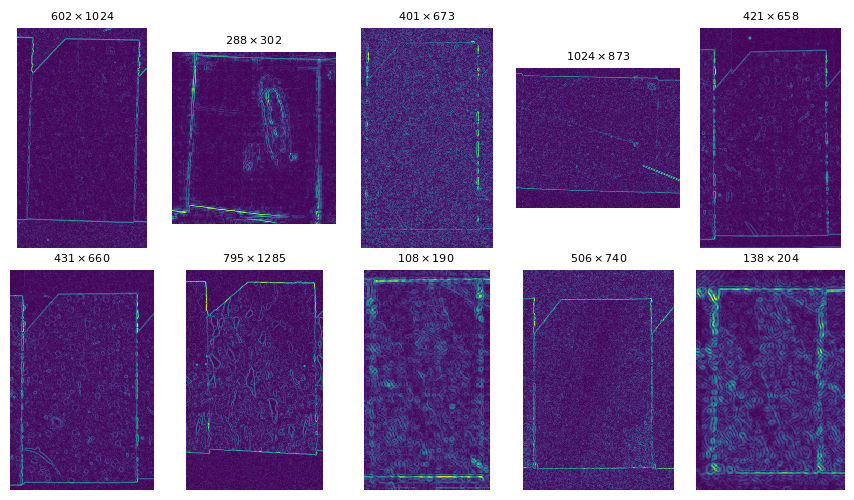

In [36]:
images_sobel = [apply_sobel_filter(img) for img in images_bf]
plot_samples(images_sobel)

In [37]:
def process_edge_image(image):
    # 1. Identifikace 11 % nejjasnějších pixelů
    flat_image = image.flatten()
    # Seřadím hodnoty pixelů a zjistíme 11 % nejjasnějších
    sorted_pixels = np.sort(flat_image)
    threshold_value = sorted_pixels[int(len(sorted_pixels) * 0.89)]  # 11 % nejjasnějších hodnot

    # Určím novou hodnotu pro nejjasnější pixely (nejnižší hodnota z těchto 11%)
    min_bright_value = np.min(sorted_pixels[sorted_pixels >= threshold_value])
    
    # Všechny hodnoty větší než threshold_value nastavím na min_bright_value
    image[image >= threshold_value] = min_bright_value

    # 2. Normalizace histogramu na interval 0–255
    min_val, max_val = np.min(image), np.max(image)
    normalized_image = np.uint8((image - min_val) / (max_val - min_val) * 255)

    # 3. Aplikace prahového filtru > 254
    thresholded_image = np.where(normalized_image > 254, 255, 0)

    return np.uint8(thresholded_image)

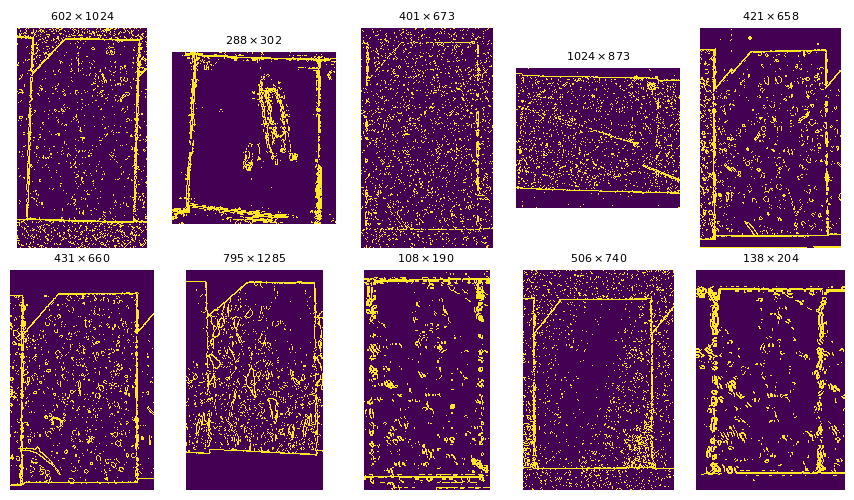

In [38]:
images_processed = [process_edge_image(img) for img in images_sobel]
plot_samples(images_processed)

In [39]:
def apply_otsu_threshold(image):
    """Aplikuje Otsuův prahový filtr a vrátí binární obraz."""
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Nastav častější hodnotu na 0 a méně častou na 255
    if np.mean(binary_image) < 127:
        binary_image = cv2.bitwise_not(binary_image)
    return binary_image

def remove_small_components(binary_image, min_area_percentage=0.15):
    """Odstraní malé spojité komponenty, jejichž plocha je menší <min_area_percentage>% plochy obrazu."""
    # Najdi všechny spojité komponenty pomocí kontur
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Rozměry obrazu
    img_h, img_w = binary_image.shape
    img_area = img_h * img_w
    min_area = min_area_percentage * img_area
    
    # Vytvoř negativní masku pro malé komponenty
    mask = np.ones_like(binary_image) * 255 # začnu bílou maskou z které budu odstraňovat malé oblasti
    
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area < min_area:
            # Pokud je oblast komponenty menší než min_area, zamaskovat
            cv2.drawContours(mask, [contour], -1, (0), thickness=cv2.FILLED)
    
    return cv2.bitwise_and(binary_image, mask)

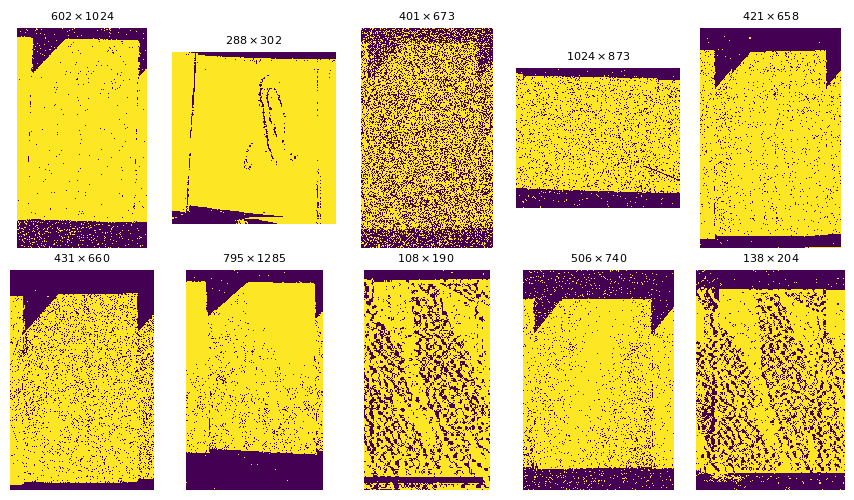

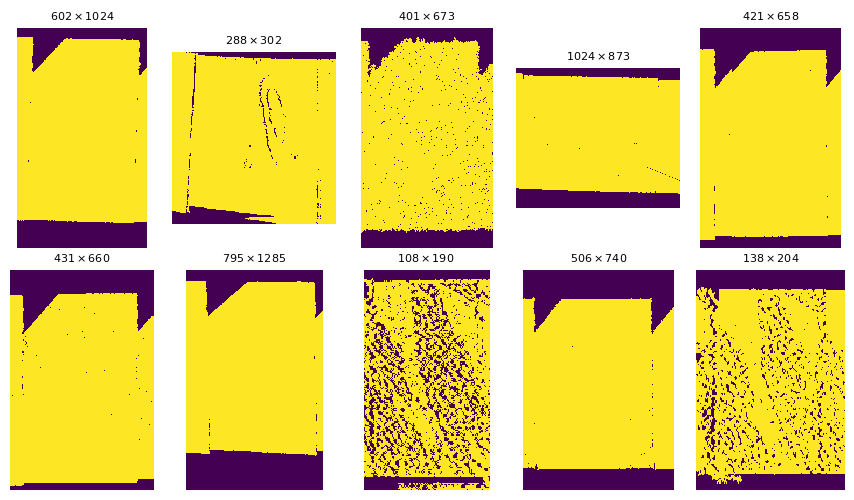

In [40]:
masks_otsu = [apply_otsu_threshold(img) for img in images]
plot_samples(masks_otsu)
masks_filtered = [remove_small_components(mask) for mask in masks_otsu]

# Vertikální dilatace masky, aby nedošlo ke zúžení horizontálních hran ze sobelova filtru
# Kernel s výškou 3 protože při sobelově filtru jsem použil 3x3 kernel 
masks_dilated = [cv2.morphologyEx(mask, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(mask.shape)//200 + 1))) for mask in masks_filtered]
plot_samples(masks_dilated)

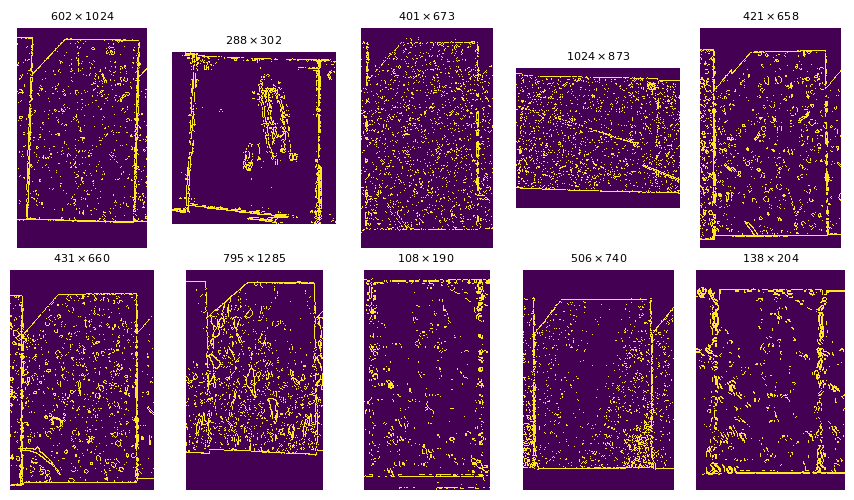

In [41]:
# Filtrace malých komponent z hranových obrázků
images_no_bad_objects = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(images_processed, masks_dilated)]
images_no_bad_objects = [img.astype(np.uint8) for img in images_no_bad_objects]
plot_samples(images_no_bad_objects)

In [42]:
import math
import scipy.stats

## Pomocné funkce pro vyhodnocování RANSAC kandidátů ##

def line_params_from_points(p1, p2):
    """Vrátí koeficienty přímky Ax + By + C = 0 z bodů p1 a p2."""
    a = p2[1]-p1[1]
    b = p1[0]-p2[0]
    c = -a*p1[0] - b*p1[1]
    norm = math.sqrt(a**2 + b**2)

    return None if norm == 0 else (a/norm, b/norm, c/norm)

def point_line_distance(p, line_abc):
    """Vrátí vzdálenost bodu p od přímky Ax + By + C = 0."""
    a, b, c = line_abc
    return abs(a*p[0] + b*p[1] + c)

def line_intersection(line1_abc, line2_abc):
    """Vrátí průsečík dvou přímek Ax + By + C = 0."""
    a1, b1, c1 = line1_abc
    a2, b2, c2 = line2_abc
    det = a1*b2 - a2*b1
    if det == 0:
        return None
    
    x = (b1*c2 - b2*c1)/det
    y = (a2*c1 - a1*c2)/det
    return int(round(x)),int(round(y))

def estimate_slice_dims(edge_image):
    """Odhaduje rozměry řezu na základě předzpracovaného a odfiltrovaného hranového obrazu."""
    img_h, img_w = edge_image.shape

    if np.sum(edge_image) == 0:
        print("Upozornění: Prázdný edge_image")
        return img_w * 0.8, img_h*0.8

    # Projekce energií přes řádky / sloupce
    row_sums = edge_image.sum(axis=1)
    col_sums = edge_image.sum(axis=0)

    # Souřadnice prvního a posledního nenulového pixelu
    topmost_idx    = np.where(row_sums > 0)[0]
    bottommost_idx = np.where(row_sums > 0)[0]
    leftmost_idx   = np.where(col_sums > 0)[0]
    rightmost_idx  = np.where(col_sums > 0)[0]

    topmost    = topmost_idx[0]
    bottommost = bottommost_idx[-1]
    leftmost   = leftmost_idx[0]
    rightmost  = rightmost_idx[-1]

    approx_width = rightmost - leftmost + 1
    approx_height = bottommost - topmost + 1

    # Zastropování na 80% rozměrů obrazu
    approx_width = min(img_w * 0.8, approx_width)
    approx_height = min(img_h * 0.8, approx_height)

    # Ošetření <1
    approx_width = max(1, approx_width)
    approx_height = max(1, approx_height)

    # print(f"Estimated dims: W={approx_width:.0f}, H={approx_height:.0f}")
    return approx_width, approx_height

def hug_score_from_otsu(line_abc, otsu_rowcumsum, img_dims, edge_type):
    """
    Vypočítá váhu poměr pixelů z popředí vůči pixelům z pozadí nad/pod hranou.
    Z optimalizačních důvodů k tomu vyžaduje kumulativní sumu nad řádky Otsuovy masky.
    """
    A, B, C = line_abc
    h, w = img_dims

    # Ověření, že přímka není téměř vertikální (B≈0)
    if abs(B) < 1e-9:
        return 1.0

    # 2) Spočítám y souřadnice hrany pro každý sloupec
    xs = np.arange(w)
    ys = np.round(-(A * xs + C) / B).astype(int)
    ys = np.clip(ys, 0, h - 1)

    # 3) Pro vrchní hranu uvažuju 0-pixely nad ní a naopak
    if edge_type == 'top':
        neg = otsu_rowcumsum[ys, xs]
        tot = ys + 1
    elif edge_type == 'bottom':
        # musím spočítat jako rozdíl součtů total-above (protože kumulativní suma zvrchu dolů)
        neg_total = otsu_rowcumsum[-1, xs]
        neg_above = otsu_rowcumsum[ys, xs]
        neg = neg_total - neg_above
        tot = (h - 1 - ys)
    else:
        raise ValueError("edge_type must be 'top' or 'bottom'")
    
    # 4) Vyloučím sloupce, kde není žádný řádek
    mask = tot > 0
    if not np.any(mask):
        return 1.0

    # 5) Poměr
    return float(neg[mask].sum() / tot[mask].sum())


def find_edge_line_ransac(edge_image, edge_type, approx_slice_dims, otsu_rowcumsum, iterations=1000, slope_factor=0.8, hug_factor=0.5):
    """Jádro algoritmu - RANSAC hledání hran"""
    img_h, img_w = edge_image.shape
    approx_w, approx_h = approx_slice_dims
    points_yx = np.argwhere(edge_image > 0)
    points_xy = points_yx[:, ::-1]
    if len(points_xy) < 2:
        return None
    
    points_g1, points_g2 = [], []
    gauss_mean, gauss_std = 0, 1
    relevant_points = points_xy

    if edge_type == 'left':
        center_x = (img_w-approx_w)/2
        gauss_mean = max(0,min(img_w-1,center_x))
        gauss_std = max(1,approx_w/3)
        relevant_points = points_xy[points_xy[:,0] < img_w*0.5]
        points_g1 = relevant_points[relevant_points[:,1] < img_h/2]
        points_g2 = relevant_points[relevant_points[:,1] >= img_h/2]
    elif edge_type == 'right':
        center_x = img_w-(img_w-approx_w)/2
        gauss_mean = max(0,min(img_w-1,center_x))
        gauss_std = max(1,approx_w/3)
        relevant_points = points_xy[points_xy[:,0] >= img_w*0.5]
        points_g1 = relevant_points[relevant_points[:,1] < img_h/2]
        points_g2 = relevant_points[relevant_points[:,1] >= img_h/2]
    elif edge_type == 'top':
        center_y = (img_h-approx_h)/2
        gauss_mean = max(0,min(img_h-1,center_y))
        gauss_std = max(1,approx_h/3)
        relevant_points = points_xy[points_xy[:,1] < img_h*0.5]
        points_g1 = relevant_points[relevant_points[:,0] < img_w/2]
        points_g2 = relevant_points[relevant_points[:,0] >= img_w/2]
    elif edge_type == 'bottom':
        center_y = img_h-(img_h-approx_h)/2
        gauss_mean = max(0,min(img_h-1,center_y))
        gauss_std = max(1,approx_h/3)
        relevant_points = points_xy[points_xy[:,1] >= img_h*0.5]
        points_g1 = relevant_points[relevant_points[:,0] < img_w/2]
        points_g2 = relevant_points[relevant_points[:,0] >= img_w/2]

    if len(points_g1) < 1 or len(points_g2) < 1:
        if len(relevant_points) < 2:
            return None
        points_g1 = relevant_points
        points_g2 = relevant_points
        
    coord_index = 0 if edge_type in ['left','right'] else 1

    probabilities_g1 = scipy.stats.norm.pdf(points_g1[:,coord_index],gauss_mean,gauss_std) if len(points_g1)>0 else np.array([])
    probabilities_g2 = scipy.stats.norm.pdf(points_g2[:,coord_index],gauss_mean,gauss_std) if len(points_g2)>0 else np.array([])

    sum_prob_g1 = np.sum(probabilities_g1)
    sum_prob_g2 = np.sum(probabilities_g2)

    if sum_prob_g1 == 0 or len(points_g1) == 0:
        probabilities_g1 = np.ones(len(points_g1))/max(1,len(points_g1))
    else:
        probabilities_g1 /= sum_prob_g1
    if sum_prob_g2 == 0 or len(points_g2) == 0:
        probabilities_g2 = np.ones(len(points_g2))/max(1,len(points_g2))
    else:
        probabilities_g2 /= sum_prob_g2

    best_line_abc = None
    best_line_fitness = -1
    best_line_hug_score = None
    inlier_threshold = max(2.0,max(img_w,img_h)/150.0)
    all_relevant_points = np.vstack((points_g1,points_g2)) if (len(points_g1)>0 and len(points_g2)>0 and not np.array_equal(points_g1,points_g2)) else relevant_points

    if len(all_relevant_points) == 0:
        return None
    
    for _ in range(iterations):
        if len(points_g1) == 0 or len(points_g2) == 0:
            continue
        
        try:
            idx1 = np.random.choice(len(points_g1), p=probabilities_g1)
            idx2 = np.random.choice(len(points_g2), p=probabilities_g2)
        except ValueError:
            continue

        p1 = points_g1[idx1]
        p2 = points_g2[idx2]

        current_line_abc = line_params_from_points(p1,p2)
        if current_line_abc == None:
            continue

        distances = np.array([point_line_distance(p, current_line_abc) for p in all_relevant_points])

        inlier_pts = all_relevant_points[distances < inlier_threshold]
        inliers_cnt = len(inlier_pts)

        # Úprava fitness na základě horizontality/vertikality
        theta     = abs(np.arctan2(current_line_abc[0], current_line_abc[1]))
        dev       = abs(theta - np.pi/2) if edge_type in ['left','right'] else min(theta, np.pi-theta)
        sigma_ang = np.deg2rad(20) # ~20° tolerance
        # Skóre následuje gaussovu křivku podle deviace z 'ideálního' úhlu
        slope_score = np.exp(-0.5 * (dev / sigma_ang)**2)

        fitness = (1-slope_factor)*inliers_cnt + (slope_factor)*(inliers_cnt*slope_score)
        #print(f"edge_type={edge_type}, angle={np.rad2deg(theta):.1f}°, dev={np.rad2deg(dev):.1f}°, σ={np.rad2deg(sigma_ang):.1f}°, weight={slope_weight:.3f}, fitness={fitness:.1f}")

        if edge_type in ['top', 'bottom']:
            # Úprava fitness na základě toho jak moc hrana "objímá" konturu řezu (pro top/bottom hranu)
            hug_score = hug_score_from_otsu(current_line_abc, otsu_rowcumsum, (img_h,img_w), edge_type)
            fitness = (1-hug_factor)*fitness + (hug_factor)*(fitness*hug_score**2)

        if fitness > best_line_fitness:
            best_line_fitness = fitness
            best_line_abc = current_line_abc
            best_line_hug_score = hug_score if edge_type in ['top', 'bottom'] else None

    print(f"Best line fitness: {best_line_fitness:.1f} for edge type {edge_type}; theta={np.rad2deg(abs(np.arctan2(best_line_abc[1], best_line_abc[0]))):.1f}°")
    if edge_type in ['top', 'bottom']:
        print(f"Best line hug_score: {best_line_hug_score:.3f} ({best_line_hug_score**2:.3f}) for edge type {edge_type}")
    
    return best_line_abc


def find_slice_corners(edge_image, otsu):
    """ Orchestrace hledání hran """

    # 1) Odhadnu rozměrů řezu
    approx_slice_dims = estimate_slice_dims(edge_image)
    if approx_slice_dims is None:
        return None
    print(f"Estimated slice dimensions: {approx_slice_dims[0]:.0f} x {approx_slice_dims[1]:.0f}")
    
    # 2) Předpočítání kumulativní sumy nad řádky z Otsu masky
    otsu_rowcumsum = np.cumsum((otsu == 0).astype(np.uint8), axis=0, dtype=np.uint32) #uint32 aby to nepřeteklo

    # 3) Hledání hran
    line_left   = find_edge_line_ransac(edge_image, 'left', approx_slice_dims, otsu_rowcumsum)
    line_right  = find_edge_line_ransac(edge_image, 'right', approx_slice_dims, otsu_rowcumsum)
    line_top    = find_edge_line_ransac(edge_image, 'top', approx_slice_dims, otsu_rowcumsum)
    line_bottom = find_edge_line_ransac(edge_image, 'bottom', approx_slice_dims, otsu_rowcumsum)

    if not all([line_left, line_right, line_top, line_bottom]):
        print("Error: Failed to find one or more edges.")
        return None
    
    # 4) Výpočet průsečíků
    tl = line_intersection(line_top, line_left)
    tr = line_intersection(line_top, line_right)
    bl = line_intersection(line_bottom, line_left)
    br = line_intersection(line_bottom, line_right)

    if not all([tl, tr, bl, br]):
        print("Error: Failed to calculate one or more intersections.")
        return None
    return {'tl': tl,'tr': tr,'br': br,'bl': bl}

Processing image 0...
Estimated slice dimensions: 92 x 150
Best line fitness: 394.6 for edge type left; theta=1.0°
Best line fitness: 278.0 for edge type right; theta=0.4°
Best line fitness: 265.5 for edge type top; theta=91.1°
Best line hug_score: 0.981 (0.962) for edge type top
Best line fitness: 236.2 for edge type bottom; theta=87.9°
Best line hug_score: 0.920 (0.846) for edge type bottom
Corners: {'tl': (13, 7), 'tr': (105, 5), 'br': (106, 178), 'bl': (10, 175)}
Time taken: 4.61 seconds


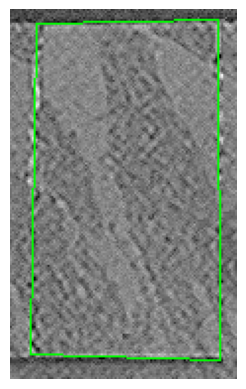

Processing image 1...
Estimated slice dimensions: 482 x 819
Best line fitness: 8591.5 for edge type left; theta=1.9°
Best line fitness: 9437.8 for edge type right; theta=1.7°
Best line fitness: 4726.1 for edge type top; theta=88.2°
Best line hug_score: 0.993 (0.987) for edge type top
Best line fitness: 5337.2 for edge type bottom; theta=88.9°
Best line hug_score: 0.996 (0.993) for edge type bottom
Corners: {'tl': (72, 42), 'tr': (566, 58), 'br': (542, 903), 'bl': (44, 893)}
Time taken: 106.92 seconds


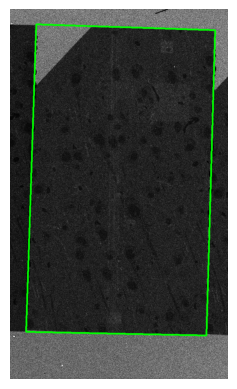

Processing image 2...
Estimated slice dimensions: 324 x 553
Best line fitness: 1071.7 for edge type left; theta=0.5°
Best line fitness: 3949.7 for edge type right; theta=0.3°
Best line fitness: 1272.2 for edge type top; theta=90.0°
Best line hug_score: 0.990 (0.980) for edge type top
Best line fitness: 1876.7 for edge type bottom; theta=90.5°
Best line hug_score: 0.985 (0.971) for edge type bottom
Corners: {'tl': (154, 82), 'tr': (337, 82), 'br': (339, 670), 'bl': (159, 672)}
Time taken: 46.98 seconds


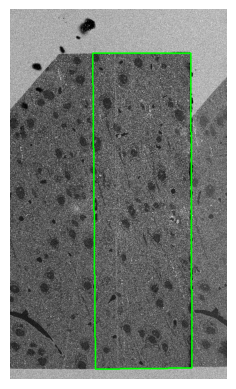

Processing image 3...
Estimated slice dimensions: 230 x 242
Best line fitness: 924.4 for edge type left; theta=3.0°
Best line fitness: 978.0 for edge type right; theta=0.0°
Best line fitness: 729.4 for edge type top; theta=88.0°
Best line hug_score: 0.905 (0.819) for edge type top
Best line fitness: 477.8 for edge type bottom; theta=84.5°
Best line hug_score: 0.683 (0.466) for edge type bottom
Corners: {'tl': (40, 5), 'tr': (257, 13), 'br': (257, 292), 'bl': (26, 270)}
Time taken: 15.57 seconds


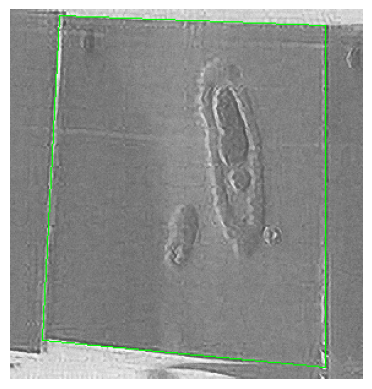

Processing image 4...
Estimated slice dimensions: 321 x 538
Best line fitness: 2146.6 for edge type left; theta=0.4°
Best line fitness: 2513.0 for edge type right; theta=0.0°
Best line fitness: 908.2 for edge type top; theta=90.4°
Best line hug_score: 0.975 (0.951) for edge type top
Best line fitness: 1179.7 for edge type bottom; theta=89.7°
Best line hug_score: 0.984 (0.968) for edge type bottom
Corners: {'tl': (19, 45), 'tr': (354, 42), 'br': (354, 616), 'bl': (15, 614)}
Time taken: 46.38 seconds


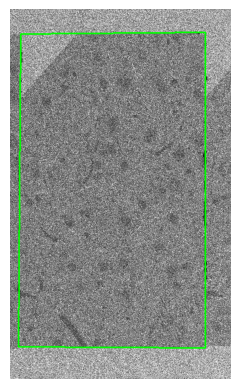

Processing image 5...
Estimated slice dimensions: 110 x 163
Best line fitness: 415.7 for edge type left; theta=0.8°
Best line fitness: 399.8 for edge type right; theta=0.7°
Best line fitness: 327.6 for edge type top; theta=90.6°
Best line hug_score: 0.943 (0.889) for edge type top
Best line fitness: 265.5 for edge type bottom; theta=89.3°
Best line hug_score: 0.922 (0.851) for edge type bottom
Corners: {'tl': (17, 19), 'tr': (116, 18), 'br': (114, 187), 'bl': (15, 186)}
Time taken: 5.21 seconds


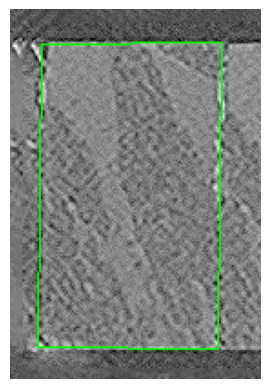

Processing image 6...
Estimated slice dimensions: 86 x 152
Best line fitness: 280.9 for edge type left; theta=0.7°
Best line fitness: 296.8 for edge type right; theta=0.9°
Best line fitness: 254.1 for edge type top; theta=89.3°
Best line hug_score: 0.962 (0.926) for edge type top
Best line fitness: 187.0 for edge type bottom; theta=89.3°
Best line hug_score: 0.696 (0.485) for edge type bottom
Corners: {'tl': (8, 7), 'tr': (99, 8), 'br': (101, 178), 'bl': (6, 177)}
Time taken: 4.18 seconds


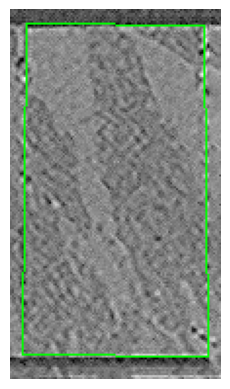

Processing image 7...
Estimated slice dimensions: 652 x 1027
Best line fitness: 13453.0 for edge type left; theta=2.2°
Best line fitness: 11376.1 for edge type right; theta=1.8°
Best line fitness: 4389.8 for edge type top; theta=91.7°
Best line hug_score: 0.992 (0.984) for edge type top
Best line fitness: 8268.2 for edge type bottom; theta=91.6°
Best line hug_score: 0.997 (0.993) for edge type bottom
Corners: {'tl': (33, 174), 'tr': (690, 155), 'br': (724, 1231), 'bl': (74, 1249)}
Time taken: 172.26 seconds


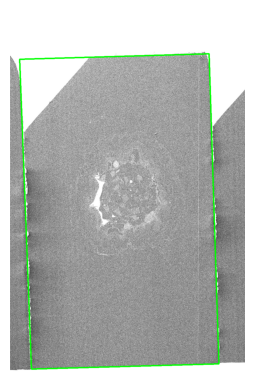

Processing image 8...
Estimated slice dimensions: 345 x 528
Best line fitness: 3875.9 for edge type left; theta=0.5°
Best line fitness: 3569.0 for edge type right; theta=0.0°
Best line fitness: 1492.4 for edge type top; theta=91.6°
Best line hug_score: 0.991 (0.982) for edge type top
Best line fitness: 1791.2 for edge type bottom; theta=90.7°
Best line hug_score: 0.974 (0.948) for edge type bottom
Corners: {'tl': (38, 77), 'tr': (379, 68), 'br': (379, 635), 'bl': (33, 640)}
Time taken: 47.28 seconds


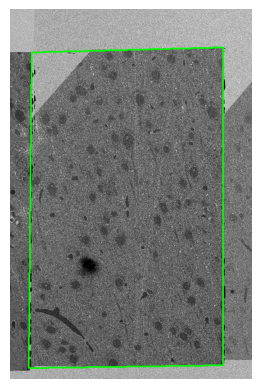

Processing image 9...
Estimated slice dimensions: 540 x 460
Best line fitness: 1167.4 for edge type left; theta=2.2°
Best line fitness: 1102.0 for edge type right; theta=0.0°
Best line fitness: 3060.1 for edge type top; theta=89.0°
Best line hug_score: 0.970 (0.941) for edge type top
Best line fitness: 3497.0 for edge type bottom; theta=88.9°
Best line hug_score: 0.995 (0.991) for edge type bottom
Corners: {'tl': (75, 34), 'tr': (622, 44), 'br': (622, 516), 'bl': (57, 505)}
Time taken: 64.09 seconds


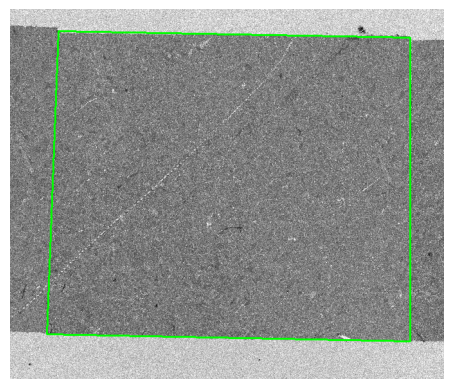

Processing image 10...
Estimated slice dimensions: 819 x 698
Best line fitness: 3491.4 for edge type left; theta=2.7°
Best line fitness: 3540.4 for edge type right; theta=1.3°
Best line fitness: 7190.2 for edge type top; theta=88.3°
Best line hug_score: 0.980 (0.961) for edge type top
Best line fitness: 8101.2 for edge type bottom; theta=88.2°
Best line hug_score: 0.990 (0.981) for edge type bottom
Corners: {'tl': (44, 43), 'tr': (893, 68), 'br': (877, 776), 'bl': (11, 748)}
Time taken: 153.64 seconds


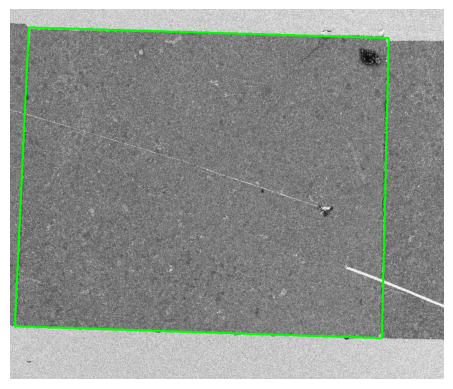

Processing image 11...
Estimated slice dimensions: 405 x 592
Best line fitness: 3938.7 for edge type left; theta=0.3°
Best line fitness: 3894.6 for edge type right; theta=0.3°
Best line fitness: 2146.3 for edge type top; theta=90.1°
Best line hug_score: 0.998 (0.997) for edge type top
Best line fitness: 2683.2 for edge type bottom; theta=90.3°
Best line hug_score: 0.995 (0.991) for edge type bottom
Corners: {'tl': (35, 97), 'tr': (430, 96), 'br': (433, 665), 'bl': (38, 667)}
Time taken: 61.15 seconds


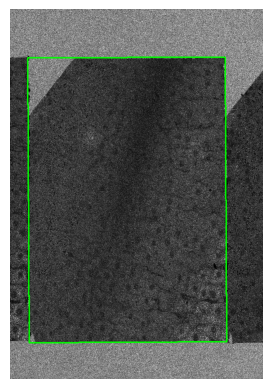

Processing image 12...
Estimated slice dimensions: 75 x 146
Best line fitness: 377.4 for edge type left; theta=4.8°
Best line fitness: 430.7 for edge type right; theta=1.7°
Best line fitness: 208.4 for edge type top; theta=76.0°
Best line hug_score: 0.963 (0.927) for edge type top
Best line fitness: 116.2 for edge type bottom; theta=87.0°
Best line hug_score: 0.944 (0.892) for edge type bottom
Corners: {'tl': (15, 6), 'tr': (80, 22), 'br': (84, 175), 'bl': (29, 172)}
Time taken: 3.77 seconds


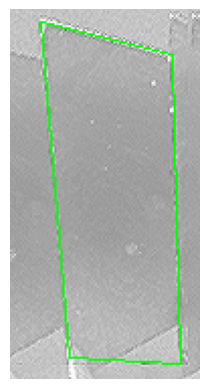

Processing image 13...
Estimated slice dimensions: 636 x 1028
Best line fitness: 7909.1 for edge type left; theta=1.3°
Best line fitness: 8663.6 for edge type right; theta=0.9°
Best line fitness: 4892.7 for edge type top; theta=89.7°
Best line hug_score: 0.989 (0.979) for edge type top
Best line fitness: 5870.8 for edge type bottom; theta=87.2°
Best line hug_score: 0.979 (0.958) for edge type bottom
Corners: {'tl': (116, 70), 'tr': (745, 73), 'br': (760, 1075), 'bl': (138, 1045)}
Time taken: 171.60 seconds


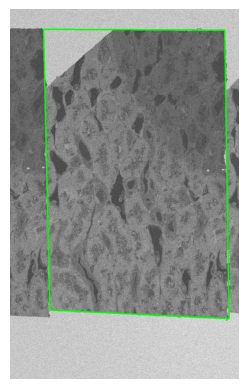

Processing image 14...
Estimated slice dimensions: 337 x 526
Best line fitness: 4034.0 for edge type left; theta=0.0°
Best line fitness: 2906.8 for edge type right; theta=0.6°
Best line fitness: 1408.6 for edge type top; theta=90.4°
Best line hug_score: 0.987 (0.974) for edge type top
Best line fitness: 1942.3 for edge type bottom; theta=90.6°
Best line hug_score: 0.967 (0.934) for edge type bottom
Corners: {'tl': (42, 70), 'tr': (375, 68), 'br': (381, 618), 'bl': (42, 622)}
Time taken: 44.71 seconds


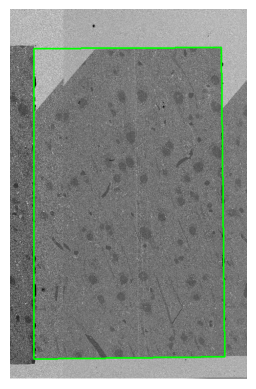

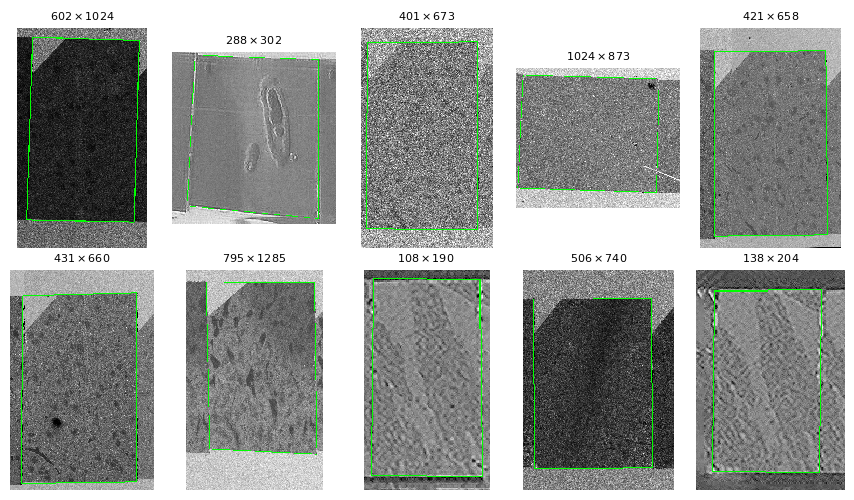

In [43]:
import time

results = []
result_images = []

# Záměrně nepoužívám dilatované Otsu masky - chci "objímat" původní konturu
for i, (orig_img, edge_img, otsu) in enumerate(zip(images, images_processed, masks_filtered)):
    print(f"Processing image {i}...")
    display_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)

    start_time = time.time()
    corners = find_slice_corners(edge_img, otsu)
    print(f"Corners: {corners}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    results.append(corners)

    if corners:
        pts = np.array([corners['tl'],corners['tr'],corners['br'],corners['bl']], np.int32).reshape((-1,1,2))
        cv2.polylines(display_img,[pts], isClosed=True, color=(0,255,0), thickness=max(1,int(min(display_img.shape[0],display_img.shape[1])/200)))
        for pt in corners.values():
            h_disp, w_disp, _ = display_img.shape
            if 0 <= pt[0] < w_disp and 0 <= pt[1] < h_disp:
                #cv2.circle(display_img, pt, radius=max(3,int(min(w_disp,h_disp)*0.01)), color=(0,0,255), thickness=-1)
                pass
            else: print(f"Warning: Corner {pt} outside image {i}")
        plot_sample(display_img)
    else:
        print(f"Failed to find corners for image {i}")

    result_images.append(display_img)

plot_samples(result_images)

### Experiment s detekcí čar v hranovém obrazu pomocí Houghovy transformace

In [ ]:
alpha = 0.7

for orig_img, edges in zip(images, images_no_bad_objects):
    lines = cv2.HoughLines(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        min_theta=np.deg2rad(-20),
        max_theta=np.deg2rad(20)
    )

    output = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    if lines is not None:
        lines = lines[:15]
        for rho, theta in lines[:,0]:
            overlay = output.copy()
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a*rho, b*rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*( a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*( a)))
            cv2.line(overlay, pt1, pt2, (0, 0,255), thickness=1)

            output = cv2.addWeighted(overlay, alpha, output, 1-alpha, 0)

    lines = cv2.HoughLines(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        min_theta=np.deg2rad(80),
        max_theta=np.deg2rad(100)
    )

    if lines is not None:
        lines = lines[:15]
        for rho, theta in lines[:,0]:
            overlay = output.copy()
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a*rho, b*rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*( a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*( a)))
            cv2.line(overlay, pt1, pt2, (0,255,0), thickness=1)

            output = cv2.addWeighted(overlay, alpha, output, 1-alpha, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(output[...,::-1])
    plt.axis('off')
    plt.show()